# How well does MCSS separate native and decoy pose pairs?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import spearmanr
import sys
sys.path.append('../../dock')
sys.path.append('../../score')
from density_estimate import DensityEstimate
from load_mcss import load_mcss
from shared_paths import shared_paths

assert shared_paths['mcss'] == 'mcss15'

%matplotlib inline

In [2]:
# Will evaluate whatever mcss is set in shared_paths
(ligand_size1, ligand_size2, mcss_size, ligs,
 rmsd1, rmsd2, gscore1, gscore2, mcss) = load_mcss()

O60885
GCR
BRAF
DTRANSP
P00749
SMO
P03951
AR
MEK1
5HT2B
P00760
CDK2
SIGMA1
JAK2
ERA
P18031
P00489
A2AR
PLK1
VITD
GLUT1
MGLUR5
STRANSP
B2AR
TRPV1
Q9Y233
P00734
MR
M3
Q16539
P00742
P56817
P07900
P24941
B1AR
CHK1


In [3]:
frac_min = np.array([m / float(min(s1, s2)) for m, s1, s2 in zip(mcss_size, ligand_size1, ligand_size2)])
frac_max = np.array([m / float(max(s1, s2)) for m, s1, s2 in zip(mcss_size, ligand_size1, ligand_size2)])
correct = [np.array([r1 < 2.0 and r2 < 2.0 for r1, r2 in zip(rmsds1, rmsds2)]) for rmsds1, rmsds2 in zip(rmsd1, rmsd2)]
glide = [np.array([g1+g2 for g1, g2 in zip(gscores1, gscores2)]) for gscores1, gscores2 in zip(gscore1, gscore2)]
norm_mcss = [np.array(m) / np.max(m+[6.0]) for m in mcss]

# MCSS properties

In [4]:
print 'Number of ligands with valid MCSS', len(ligand_size1)

Number of ligands with valid MCSS 318


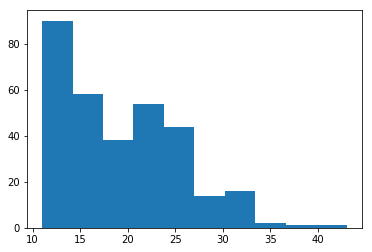

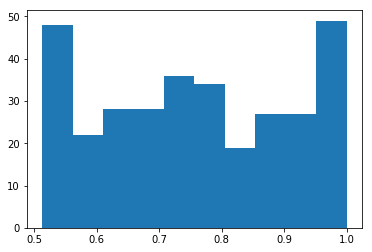

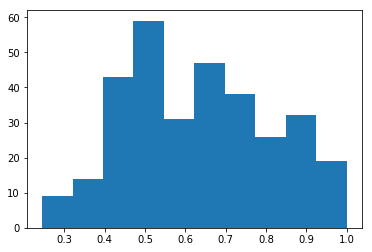

In [5]:
plt.hist(mcss_size)
plt.show()
plt.hist(frac_min)
plt.show()
plt.hist(frac_max)
plt.show()

# Overall Seperation

In [6]:
def evaluate(flat):
    native = flat[flat[:, 0]==1, 1]
    decoy  = flat[flat[:, 0]==0, 1]

    plt.hist([native, decoy], normed = True)
    plt.show()

    # Discriminatory power
    print roc_auc_score(flat[:, 0]==1, -flat[:, 1])
    tpr, fpr, thresh = roc_curve(flat[:, 0]==1, flat[:, 1])
    plt.plot(fpr, tpr)
    plt.show()

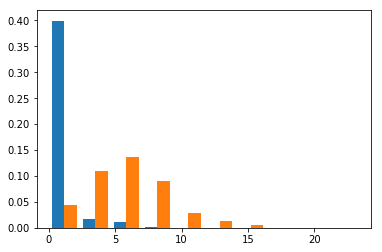

0.961916805181


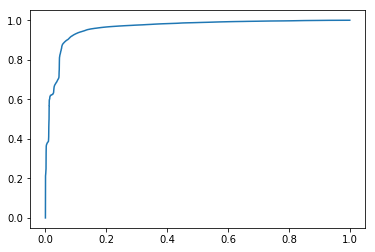

In [17]:
data = np.vstack([[__c for _c in correct for __c in _c], [__m for _m in mcss for __m in _m ]]).T
evaluate(data)

# Seperation averaged over ligands

In [19]:
def get_aucs(correct, mcss):
    aucs = []
    for c, m, g in zip(correct, mcss, glide):
        if c.min() == c.max():
            aucs += [0.5]
        else:
            aucs  += [roc_auc_score(1-c, m)]
    return aucs

aucs = get_aucs(correct, mcss)
print np.mean(aucs)

0.713389273273


0.879093792742


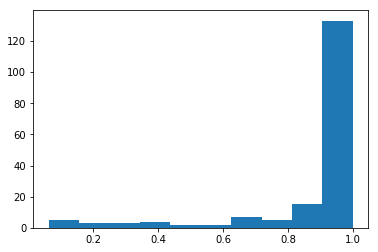

In [20]:
plt.hist(np.array(aucs)[np.array(aucs) != 0.5])
print np.array(aucs)[np.array(aucs) != 0.5].mean()
plt.show()

SpearmanrResult(correlation=0.10022271467083267, pvalue=0.18192281933169344)


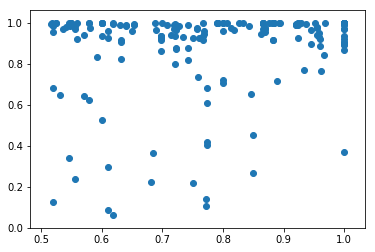

SpearmanrResult(correlation=0.047847133900086353, pvalue=0.52475641878544821)


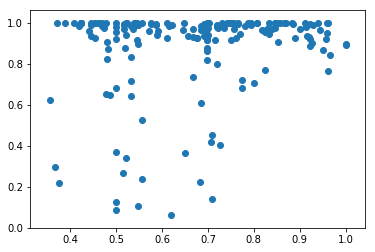

In [21]:
plt.scatter(frac_min[np.array(aucs) != 0.5], np.array(aucs)[np.array(aucs) != 0.5])
print spearmanr(np.array(aucs)[np.array(aucs) != 0.5], frac_min[np.array(aucs) != 0.5])
plt.show()

plt.scatter(frac_max[np.array(aucs) != 0.5], np.array(aucs)[np.array(aucs) != 0.5])
print spearmanr(np.array(aucs)[np.array(aucs) != 0.5], frac_max[np.array(aucs) != 0.5])
plt.show()

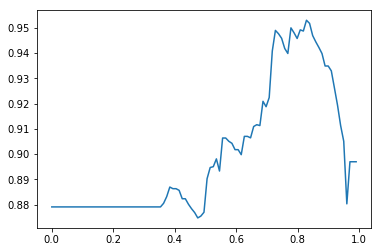

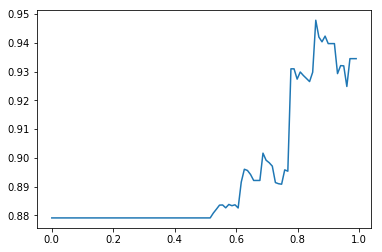

In [29]:
X, y = np.linspace(0, 1, 100), []
for x in X:
    y += [np.mean((np.array(aucs)[np.array(aucs) != 0.5])[frac_max[np.array(aucs) != 0.5] > x])]
plt.plot(X, y)
plt.show()


X, y = np.linspace(0, 1, 100), []
for x in X:
    y += [np.mean((np.array(aucs)[np.array(aucs) != 0.5])[frac_min[np.array(aucs) != 0.5] > x])]
plt.plot(X, y)
plt.show()

# Separation using energy term

- Note that this is only important in terms of calibration with glide score
- Since the energy function is monotonic, rankings will be the same regardless.

In [12]:
def get_aucs(w, ratio, correct, glide, mcss):
    aucs = []
    for c, m, g in zip(correct, mcss, glide):
        if c.min() == c.max(): continue
        mcss_score = np.array([-np.log(ratio(_m)) for _m in m])
        score = w*g + mcss_score
        aucs  += [roc_auc_score(1-c, score)]
    return aucs

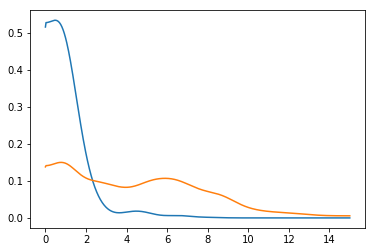

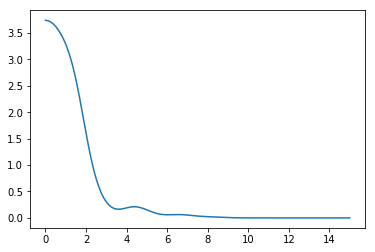

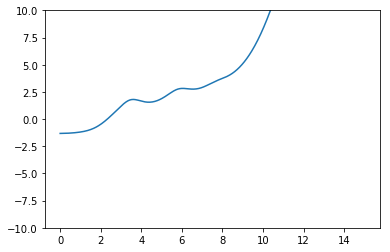

In [13]:
# Un-normalized
data = np.vstack([[__c for _c in correct for __c in _c], [__m for _m in mcss for __m in _m ]]).T

native = DensityEstimate(reflect=True, domain = (0, 15), points = 500, sd = 0.6).fit(data[data[:, 0]==1, 1])
reference = DensityEstimate(reflect=True, domain = (0, 15), points = 500, sd = 0.6).fit(data[:, 1])
plt.plot(native.x, native.fx)
plt.plot(reference.x, reference.fx)
plt.show()

ratio = native.ratio(reference)
plt.plot(ratio.x, ratio.fx)
plt.show()
plt.plot(ratio.x, -np.log(ratio.fx))
plt.ylim(-10, 10)
plt.show()

In [14]:
W = np.linspace(0, 3, 9)
for w in W:
    aucs = get_aucs(w, ratio, correct, glide, mcss)
    print w, np.mean(aucs)

0.0 0.879486005091
0.375 0.919991784343
0.75 0.922208187134
1.125 0.919403667845
1.5 0.91499122129
1.875 0.910825673437
2.25 0.907184879393
2.625 0.903756107859
3.0 0.900336474666


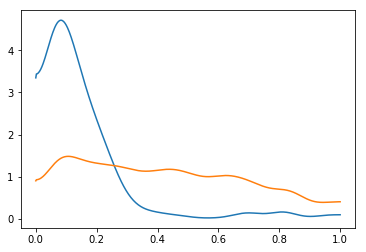

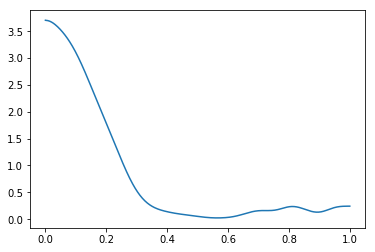

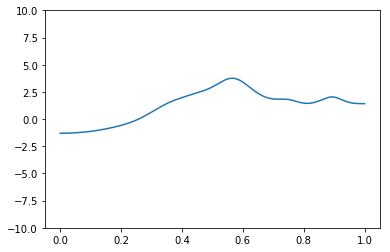

In [15]:
# Normalized
data = np.vstack([[__c for _c in correct for __c in _c], [__m for _m in norm_mcss for __m in _m ]]).T

native = DensityEstimate(reflect=True, domain = (0, 1), points = 500, sd = 0.6/15.0).fit(data[data[:, 0]==1, 1])
reference = DensityEstimate(reflect=True, domain = (0, 1), points = 500, sd = 0.6/15.0).fit(data[:, 1])
plt.plot(native.x, native.fx)
plt.plot(reference.x, reference.fx)
plt.show()

ratio = native.ratio(reference)
plt.plot(ratio.x, ratio.fx)
plt.show()
plt.plot(ratio.x, -np.log(ratio.fx))
plt.ylim(-10, 10)
plt.show()

In [16]:
W = np.linspace(0, 3, 9)
for w in W:
    aucs = get_aucs(w, ratio, correct, glide, norm_mcss)
    print w, np.mean(aucs)

0.0 0.858937150604
0.375 0.905317572395
0.75 0.913516351086
1.125 0.911314203226
1.5 0.907368379743
1.875 0.903201551158
2.25 0.899013545873
2.625 0.894948346935
3.0 0.891075508567
